In [0]:
!pip install swifter
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
sns.set(style='white')
import pandas as pd
import pickle, requests, community
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
from tqdm import tqdm_notebook
from collections import Counter
from fa2 import ForceAtlas2
from matplotlib.lines import Line2D
import swifter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)


# Brexit Analysis

## Introduction

This IPython notebook contains the main code used for the Brexit Analysis. The aim of this project is analize the reactions to Brexit, paying attention to the british politicians and the citizens of the United Kingdom (UK), in order to provide an overview of the evolution of the whole process during the last three years and check how can we make conclusions using sources like Twitter, Wikipedia or The Guardian.

We will provide details about our dataset: which are our data sources, how we have obtained all the information, why we have selected this dataset or the problems we've faced while obtaining the data. Then we will generate a network with the members from the House of Commons (HOC) in the UK and compute some measures to support our analysis. In addition to that, we will explain how we have performed all the text analysis that we have done. Finally, we will provide some conclusions after all the process.

## Our Dataset

In order to get all the necessary information for this project we have elaborated a dataset containing representative data from different data sources.

### Data Sources

The dataset has been elaborated using three different data sources:
- Wikipedia: we have extracted the list of members of the HOC and all the links to their respective Wikipedia pages, in order to download the source text of each page and store the links between them to build a network.
- Twitter: using the _GetOldTweets3_ library we have filter and downloaded tweets from 2016 until now using some hashtags related with Brexit. Then we grouped the hashtags in three different categories according their intentionality:
  - General hashtags (neutral): #brexit, #referendum, #eureferendum, #euref, #ivoted and #brexitvote.
  - Leave hashtags (pro-Brexit): #voteleave, #leave, #no2eu and #voteout.
  - Stay hashtags (anti-Brexit): #remain, #strogerin, #voteremain, #votein and #bremain.

  With this classification we have grouped tweets from the public opinion and from the members of the HOC for the text analysis.

  Moreover, we have downloaded and filtered the retweets between the members of the HOC to build the network that it's going to be analysed in this notebook.
- The Guardian: we have used _The Guardian API_ for Python to filter the top 10 most relevant Brexit’s news for each month since 2016 until now, saving only their headlines. Then, manually, we have selected the best top 3 for each month to have a good overview of the process over time (ordering by relevance not always worked as expected).

To storage all this information we have needed less than 90 megabytes. Then we have been creating several files to adapt the data to each part of the code and save some statistics and measures used for the Brexit Analysis.


### Discarded Sources

At the beginnning of this project, in addition to the data sources already mentioned, we decided to use Facebook and the BBC website as data sources for our project. However, we faced difficulties when trying to download the information:

- We tried to use the Facebook for Developers Tool and its API in order to download the body and the comments for some of the news related with Brexit posted on the BBC's Facebook public page. In order to download content from public pages on Facebook it's necessary to have the permission _Page Public Content Access_, and one of the requirements to obtain this permission is verify your business. Due to this limitation we decided to try to get this information directly from the BBC website.

- We used _BeautifulSoup_ Python's library to read the HTML code from the BBC webpage. Then, we tried to get the headlines and the comments from the Brexit news of the last three years, but we didn't find a way. Filter properly this kind of news and automatize the process was very difficult, so we finally decided to look for other methods to get the headlines for the timeline.

Looking on internet we found The Guardian API, previously mentioned, that provides an easy way to filter and recover the headlines related with Brexit for the last three years.

## Code Structure

Not all the code that we have used for this project it's in this notebook. We have written several files, each of them with a different purpose, and they can be classified as follows:

- Code to download data from the data sources and build the project's dataset: with these files we have generated JSON and CSV files containing information without any processing.

- Code to transform and process data from the dataset: with this code we have created several CSV files containing the original data from the project's dataset and other data necessary for the Brexit Analysis, such as statistics, sentiment scores, etc.

- Project utilities: one big file with Python functions that are used in many parts of this project in order to avoid repeating code and standardize.

- Code included in this IPython notebook: it's the most relevant code of the project and it computes the main measures and plots.

- Code for the visualization of the website: JavaScript code to build the Observable that we have used as website to show the final result of our project.

## House of Commons Network Analysis

In this section we are gooing to build the network with all the politicians from the House of Commons. Previously we built other network with the members of the HOC using data from Wikipedia, but finally we haven't include it because we consider that it doesn't contribute with more information than this Twitter network.

As first step we load some part of our dataset containing all their information that we scaped from Twitter. As you can see below, in _twitter_network.csv_ we have the politician's name, Twitter name and party for every member of the House of Commons elected in 2017. Meanwhile, the file _tweeter_links.pkl_ contains all the links between the politicians based on the retweets between them.

In [0]:
#import dataset
house_of_commons = pd.read_csv('twitter_network.csv', index_col=0)
links_dictionary = pickle.load(open('tweeter_links.pkl', 'rb'))

In [0]:
# keep only members that we have links for
names_with_links = list(links_dictionary.keys())
house_of_commons = house_of_commons[house_of_commons.twi_handle.isin(names_with_links)]

In [0]:
#dictionary that maps names to handles
names_to_handles = house_of_commons[['Name', 'twi_handle']].set_index('Name').to_dict(orient='dict')['twi_handle']
handles_to_names = {v: k for k, v in names_to_handles.items()}


In [0]:
house_of_commons.head()

Name       twi_handle         Party
0     Adam Afriyie     @AdamAfriyie  Conservative
1      Alan Duncan    @AlanDuncanMP  Conservative
3    Alberto Costa  @AlbertoCostaMP  Conservative
4  Alec Shelbrooke  @AlecShelbrooke  Conservative
5    Alex Burghart    @alexburghart  Conservative

In [0]:
house_of_commons.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 586
Data columns (total 3 columns):
Name          541 non-null object
twi_handle    541 non-null object
Party         541 non-null object
dtypes: object(3)
memory usage: 16.9+ KB


### Party Dynamics

In the figure below you can see how many members of the house belongs to each party.

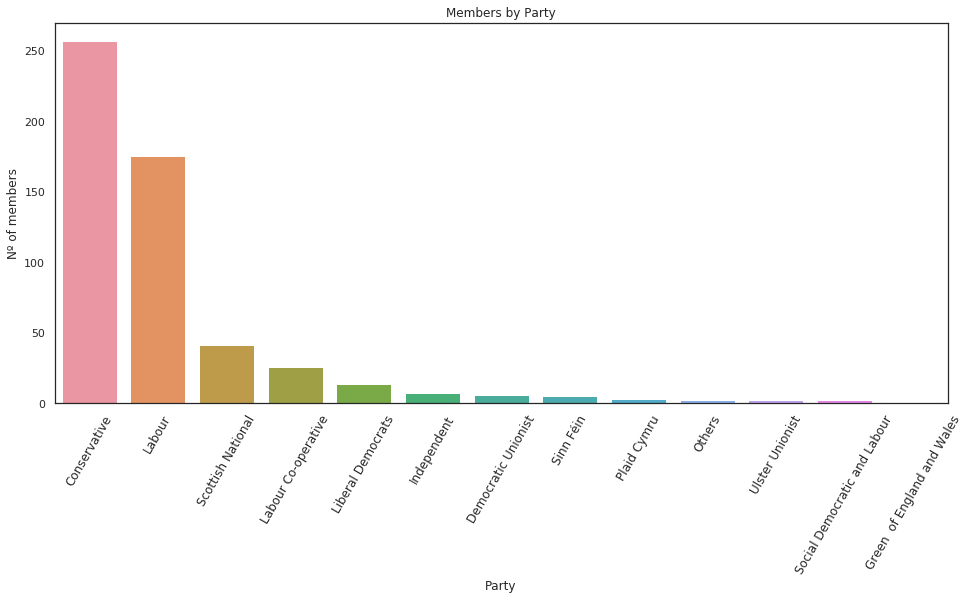

In [0]:
plt.figure(figsize=(16,7))
sns.countplot(house_of_commons.Party,
              order=house_of_commons.Party.value_counts().index)
plt.xticks(fontsize=12, rotation='60')
plt.ylabel("Nº of members")
plt.title("Members by Party")
plt.show()

### The Network
Now we will create a network with the names of each Member of the House of Commons (HOC) as its nodes, and the retweets between them as its edges.

In [0]:
# create a directed graph
G = nx.DiGraph()

# add nodes
G.add_nodes_from(list(house_of_commons.twi_handle))
for name in G.nodes:
    # create the edges list excluding the nodes name to avoid self loops
    edges = [(name, '@'+str(link)) for link in links_dictionary[name] 
             if (link != name and '@'+str(link) in set(G.nodes))]
    # create a Counter to store the number of same egdes e.g number of retweets
    count = Counter(edges)
    # adding the edges to the graph using the number of retweets as weight
    for edge, weight in count.items():
        G.add_edge(*edge, weight=weight)

# set attributes for each node
nx.set_node_attributes(G, 
                       house_of_commons.set_index('twi_handle')
                       .to_dict('index'))

#remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))

#Create undirected graph
undirected = G.to_undirected()

In [0]:
# set our color palette
"""We are going to use it for parties beside Labour Party and Conservatives"""
palette = sns.color_palette("Set2", n_colors=len(set(house_of_commons.Party)))
#map every party to an int in order to select colors
party_map = {party:i for i,party in enumerate(set(house_of_commons.Party))}
palette[party_map['Conservative']] = 'blue'
palette[party_map['Labour']] = 'red'

#create the list of colors
node_color  = []
for node in undirected.nodes(data=True):
    if node[1]['Party'] == 'Conservative':
        node_color.append('blue')
    elif node[1]['Party'] == 'Labour':
        node_color.append('red')
    else:
        node_color.append(palette[party_map[node[1]['Party']]])

In [0]:
#create legends fot the graph plot
legend_elements = [Line2D([0], [0], marker='o', 
                          color=palette[party_map[party]], 
                          label=party,
                          markersize=15
                          )
                   for party in party_map.keys()]

In [0]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1,

                        # Performance
                        jitterTolerance=0.5,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=5.0,
                        strongGravityMode=True,
                        gravity=10,

                        # Log
                        verbose=False)
# force Atlas doesn't work with undirected graphs
positions = forceatlas2.forceatlas2_networkx_layout(undirected, pos=None, iterations=2000)

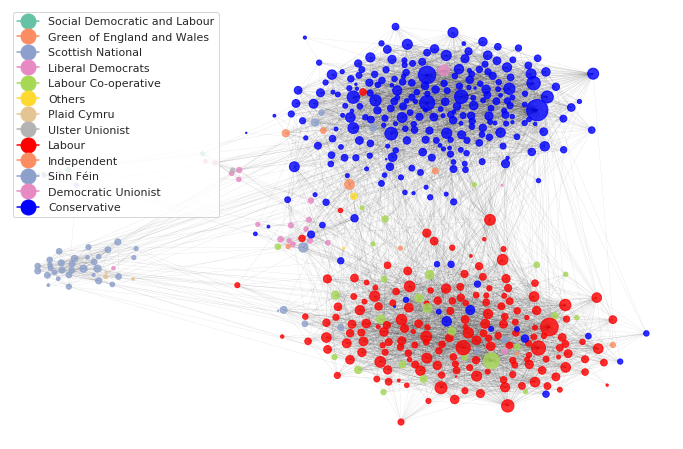

In [0]:
nx.draw_networkx(undirected, positions, 
                 node_size=[2*v  for v in dict(nx.degree(undirected)).values()], 
                 with_labels=False, width=0.05, node_color=node_color, alpha=0.8)
plt.axis('off')
plt.legend(handles=legend_elements, loc='best')
plt.show()

### Network Statistics

In [0]:
avg_degree = sum(dict(G.degree()).values())//len(G.nodes)
nb_nodes = len(G.nodes)
nb_edges = len(G.edges)
density = nx.density(G)

print('Average Degree: ', avg_degree)
print('Number of Nodes: ', nb_nodes)
print('Number of Edges:', nb_edges)
print('Network Density: ', density)


Average Degree:  25
Number of Nodes:  531
Number of Edges: 6842
Network Density:  0.024311551718011585


### Most Influential Members of the HOC

We will try to find the most influetial members of the HOC based on their connectivity. Later we will use these members in an attempt to explain how they affect the political scene in general and the specifically the #Brexit situation.
We will measure connectivity using centrality. There are many different ways to measure centrality which explore different attributes of the network.

The ones we will use are:

- **Degree Centrality:** 
Is one of the easiest to calculate. The degree centrality of a node is simply its degree—the number of edges it has. The higher the degree, the more central the node is. This can be an effective measure, since many nodes with high degrees also have high centrality by other measures.

- **Betweenness Centrality:** 
Represents the degree to which nodes stand between each other in the network. For every pair of nodes in the network, there exists at least one shortest path between these nodes. The betweenness centrality for each node is the number of these shortes pass that pass through the node. Intuitively it represent how _central_ the node is in the network.

- **Eigenvector centrality:**
Is a measure of the influence the node has in the network. Relative scores are assigned to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. A high eigenvector score means that a node is connected to many nodes who themselves have high scores.

- **PageRank:**
Is the algorithm used originally by google to rank webpages in their search engine results. PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites.

In [0]:
house_of_commons['DegreeCentrality'] = house_of_commons.twi_handle.map(nx.degree_centrality(G))
house_of_commons['BetweennessCentrality'] = house_of_commons.twi_handle.map(nx.betweenness_centrality(G))
house_of_commons['EigenVectorCentrality'] = house_of_commons.twi_handle.map(nx.eigenvector_centrality_numpy(G))
house_of_commons['PageRank'] = house_of_commons.twi_handle.map(nx.pagerank(G,alpha=0.9))
house_of_commons.fillna(0, inplace=True)

In [0]:
house_of_commons.head()

Name       twi_handle  ... EigenVectorCentrality  PageRank
0     Adam Afriyie     @AdamAfriyie  ...         -1.308186e-18  0.000191
1      Alan Duncan    @AlanDuncanMP  ...          8.233313e-03  0.000453
3    Alberto Costa  @AlbertoCostaMP  ...          2.326464e-03  0.000325
4  Alec Shelbrooke  @AlecShelbrooke  ...          1.964552e-03  0.000305
5    Alex Burghart    @alexburghart  ...         -8.902036e-19  0.000197

[5 rows x 7 columns]

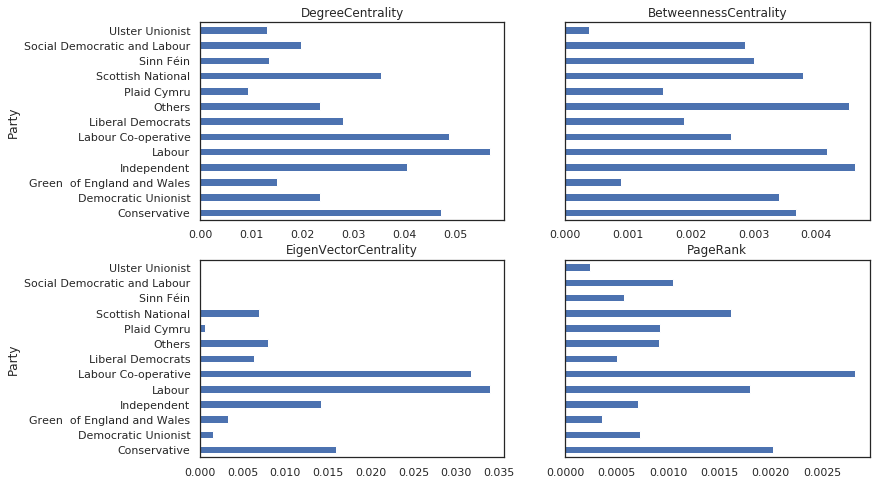

In [0]:
party_means = house_of_commons.groupby('Party').mean()
plt.figure()
plt.subplot(2, 2, 1)
plt.gca().set_title('DegreeCentrality')
party_means['DegreeCentrality'].plot(kind='barh')
plt.subplot(2, 2, 2)
plt.gca().set_title('BetweennessCentrality')
party_means['BetweennessCentrality'].plot(kind='barh')
plt.yticks([])
plt.ylabel('')

plt.subplot(2, 2, 3)
plt.gca().set_title('EigenVectorCentrality')
party_means['EigenVectorCentrality'].plot(kind='barh')

plt.subplot(2, 2, 4)
plt.gca().set_title('PageRank')
party_means['PageRank'].plot(kind='barh')
plt.yticks([])
plt.ylabel('')

plt.show()

In the last figure there's a comparision of the centrality values for all the parties in the HOC. It can be observed that the Labour, the Labour Co-operative and the Conservative parties are the most influencial ones. Moreover, we can see that the Eigenvector Centrality penalizes more those parties that are not close to the most influencial.

PageRank shows us a different measure compared to the rest of the bar plots, something closer to how many influence does each party has online and the quality of the information that you can find in the webpages about them. This difference can be appreciated easily in the next plots, where the four measures are plotted against each other to see the similarities between them. PageRank compared to the other 3 measures generates uncorrelated plots, while the case it's the opposite when comparing the centrality measures.

<Figure size 1080x1080 with 0 Axes>

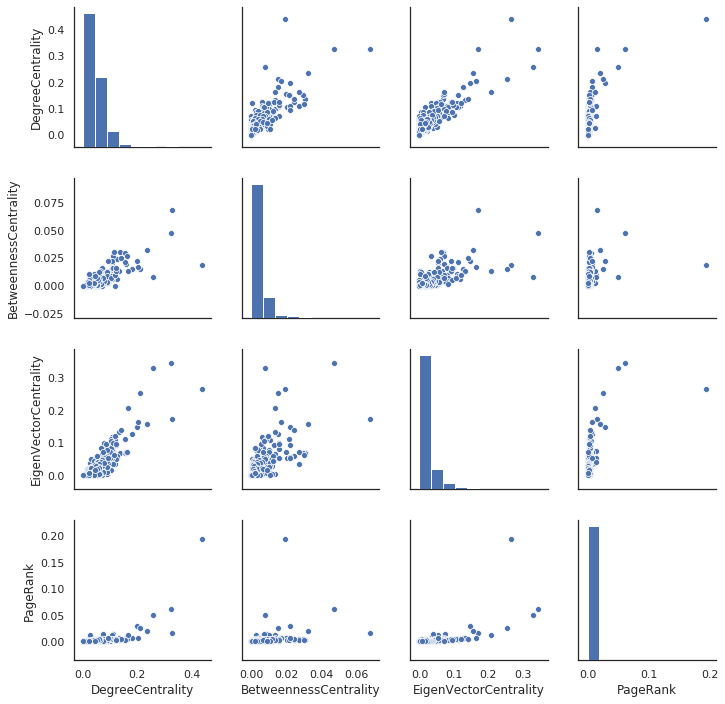

In [0]:
plt.figure(figsize=(15,15))
sns.pairplot(house_of_commons.drop('twi_handle',axis=1))

#### Degree Centrality

The next plot shows the distribution for the degree centrality values in the network.

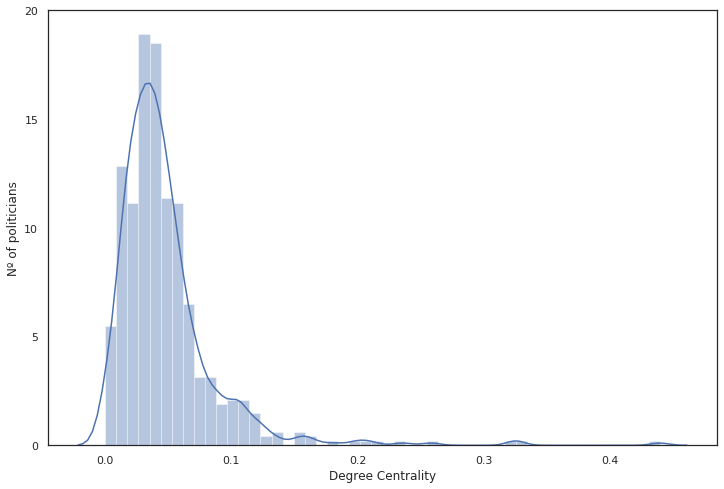

In [0]:
yaxis = np.array([0,5,10,15,20])
sns.distplot(house_of_commons.dropna().DegreeCentrality)
plt.xlabel("Degree Centrality")
plt.yticks(yaxis)
plt.ylabel("Nº of politicians")
plt.show()

Given the previous description of the degree centrality, let's just plot the network using it's value for each node's size.

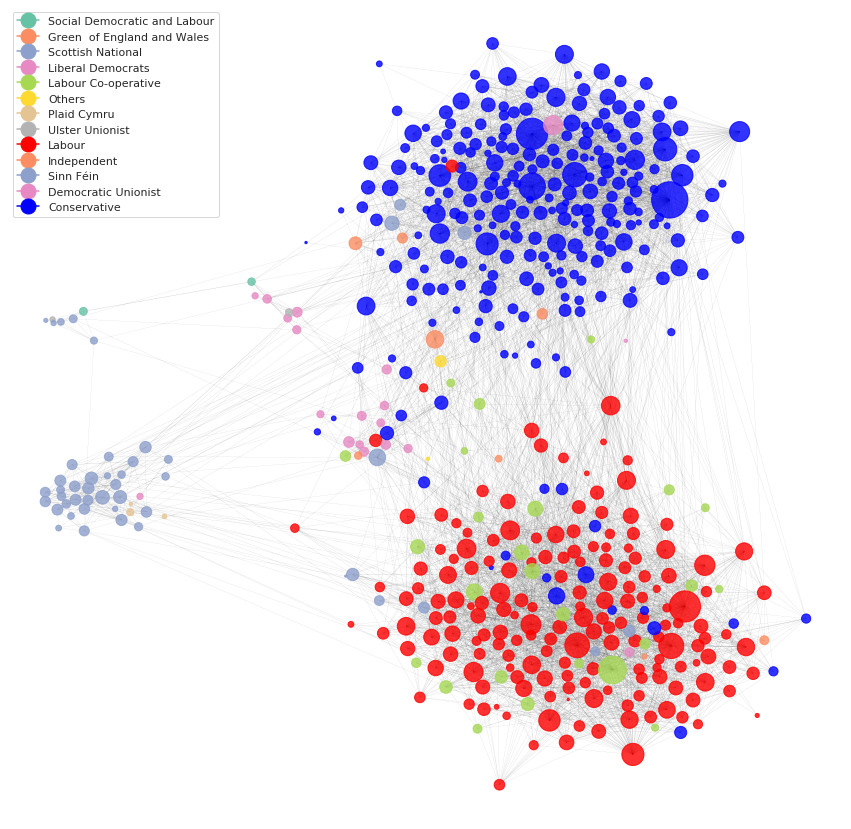

In [0]:
plt.figure(figsize=(15,15))
nx.draw_networkx(undirected, positions, 
                 node_size=[ 3000*nx.degree_centrality(G)[v] for v in undirected.nodes], 
                 with_labels=False, width=0.05, node_color=node_color, alpha=0.8)
plt.axis('off')
plt.legend(handles=legend_elements, loc='best')
plt.show()

The network looks similar to the one plotted previously in this notebook. This is just because we already used the degree to define the size of each node.

Below we have the ranking of the 5 politicians with the highest degree:

In [0]:
#initiate a set to store the top politician for every metric
top = set()
top_by_degree = set(house_of_commons.sort_values(by='DegreeCentrality', 
                                                 ascending=False)['Name'].head(5))
top = top.union(top_by_degree)

house_of_commons.sort_values(by='DegreeCentrality', 
                             ascending=False)[['Name', 'Party']].head()

Name                Party
28       Boris Johnson         Conservative
159    Matthew Hancock         Conservative
380      Jeremy Corbyn               Labour
395  Jonathan Ashworth  Labour Co-operative
214        Sajid Javid         Conservative

#### Betweenness Centrality

The plot below shows the distribution of the Betweenness Centrality values, with most of the nodes having a very low value.

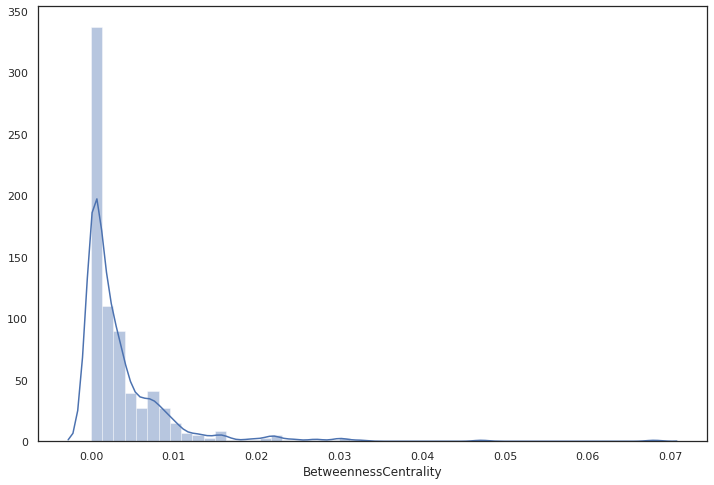

In [0]:
sns.distplot(house_of_commons.dropna().BetweennessCentrality)

Given the previous description of the betweenness centrality, let's  plot the network using it's value for each node's size.

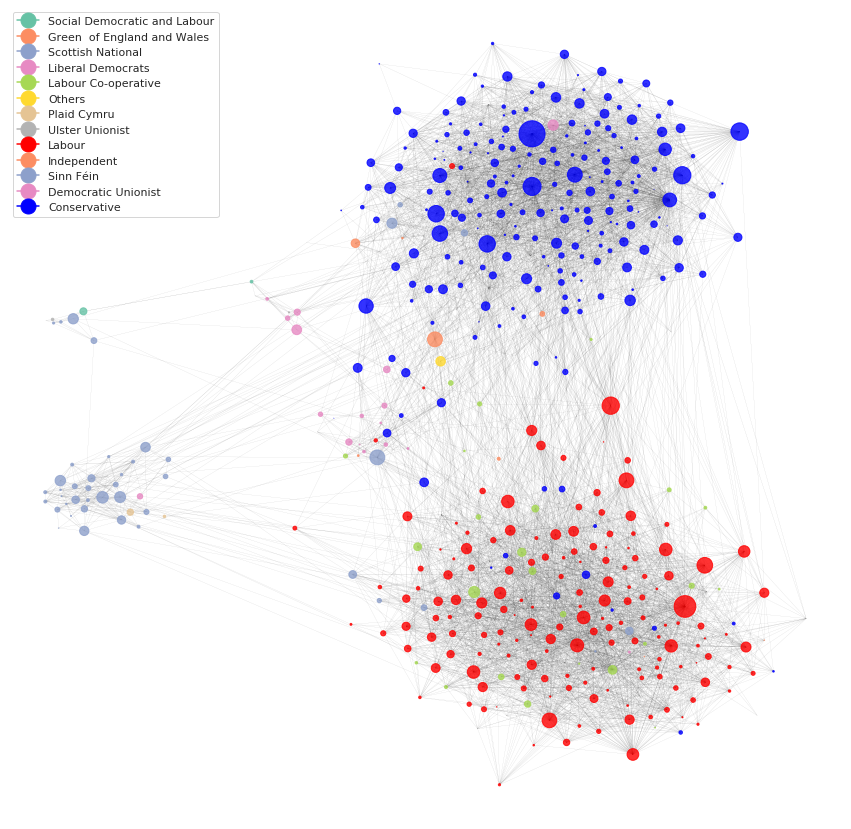

In [0]:
betweenness_centrality = nx.betweenness_centrality(G)
plt.figure(figsize=(15,15))
nx.draw_networkx(undirected, positions, 
                 node_size=[ 10000*betweenness_centrality[v] for v in G.nodes], 
                 with_labels=False, width=0.05, node_color=node_color, alpha=0.8)
plt.axis('off')
plt.legend(handles=legend_elements, loc='best')
plt.show()

As we said, the fact that most nodes have a very low value for the betweenness centrality makes a network where only a few nodes stand out above the rest. These nodes are the most _central_ ones and they have an important role in their parties.

Below it's the top 5 ranking with the nodes with the highest betweenness centrality value.

In [0]:
top_by_betweeness = set(house_of_commons.sort_values(by='BetweennessCentrality', ascending=False)['Name'].head(5))
top = top.union(top_by_betweeness)
house_of_commons.sort_values(by='BetweennessCentrality', ascending=False)[['Name', 'Party']].head()

Name         Party
159  Matthew Hancock  Conservative
380    Jeremy Corbyn        Labour
214      Sajid Javid  Conservative
12    Andrea Leadsom  Conservative
421    Lindsay Hoyle        Labour

#### EigenVector Centrality

The plot below shows the distribution of the Eigenvector Centrality values, with most of the nodes having a very low value as it happened with the previous computed measure.

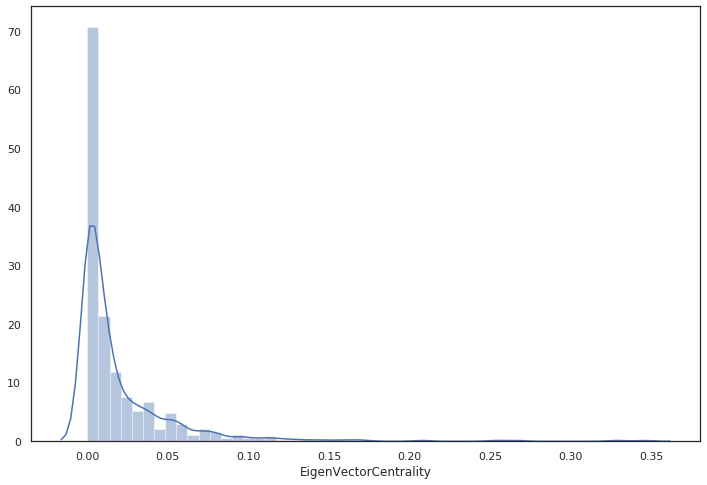

In [0]:
sns.distplot(house_of_commons.dropna().EigenVectorCentrality)

Given the previous description of the eigenvector centrality, let's plot the network using it's value for each node's size.

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


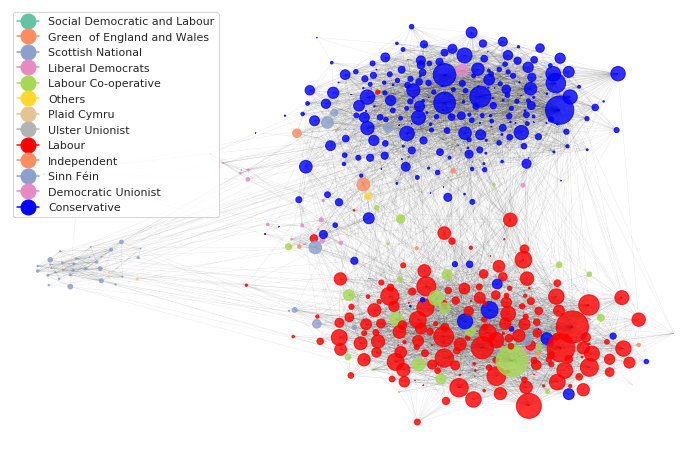

In [0]:
eigenvector_centrality = nx.centrality.eigenvector_centrality_numpy(G)
nx.draw_networkx(undirected, positions, 
                 node_size=[ 3000*eigenvector_centrality[v] for v in G.nodes], 
                 with_labels=False, width=0.05, node_color=node_color, alpha=0.8)
plt.axis('off')
plt.legend(handles=legend_elements, loc='best')
plt.show()

The nodes belonging to the two most important parties (Conservative and Labour) are the ones with a higher eigenvector centrality value. Also the nodes maintaining a close relation with members of these parties have a high value. There's not a big difference between higher and lowest values.

This reasoning can be checked by looking at the top 5 ranking of politicians with higher eigenvector centrality values.

In [0]:
top_by_eigen = set(house_of_commons.sort_values(by='EigenVectorCentrality', ascending=False)['Name'].head(5))
top = top.union(top)
house_of_commons.sort_values(by='EigenVectorCentrality', ascending=False)[['Name', 'Party']].head()

Name                Party
380      Jeremy Corbyn               Labour
395  Jonathan Ashworth  Labour Co-operative
28       Boris Johnson         Conservative
391     John McDonnell               Labour
297      Angela Rayner               Labour

#### PageRank

Now we are going to plot the distribution of the PageRank value as the last computed measure for this network. As you can see in the plot below, the difference between the lower values and the higher ones it's big compared to previous measures. Most of the values are low but there's an important percentage of the total with higher values.

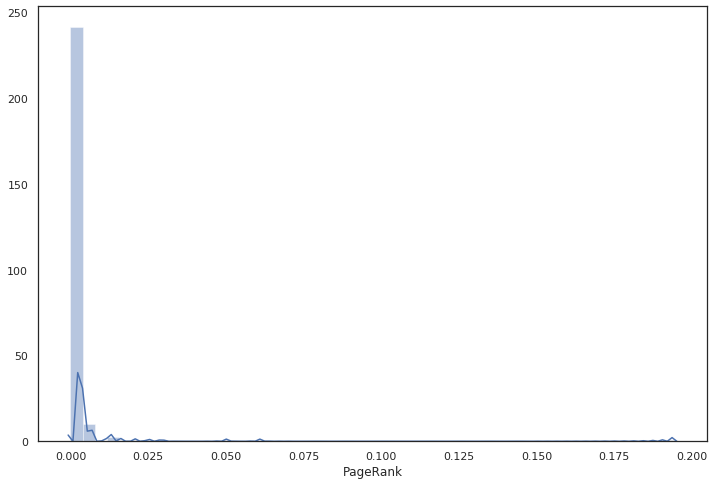

In [0]:
sns.distplot(house_of_commons.dropna().PageRank)

Let's plot one last time the network using this values for the node's size.

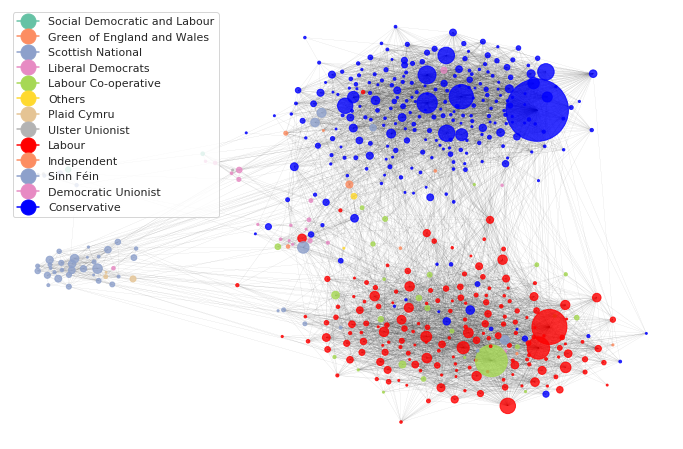

In [0]:
pagerank = nx.pagerank(G,alpha=0.9)
nx.draw_networkx(undirected, positions, 
                 node_size=[ 20000*pagerank[v] for v in undirected.nodes], 
                 with_labels=False, width=0.05, node_color=node_color, alpha=0.8)
plt.axis('off')
plt.legend(handles=legend_elements, loc='best')
plt.show()

PageRank is a good measure in this case to identify the most important members of each party. It's easy to detect the leaders of the Conservative, the Labour and the Labour Co-operative parties with a quick look to the network. Could be useful to determine which are the most powerful politicians in the HOC.

The top 5 ranking below shows the politicians with the highest PageRank value.

In [0]:
top_page_rank = list(house_of_commons.sort_values(by='PageRank', ascending=False)['Name'].head(5))
top = top.union(top_page_rank)
house_of_commons.sort_values(by='PageRank', ascending=False)[['Name', 'Party']].head(5)

Name                Party
28       Boris Johnson         Conservative
380      Jeremy Corbyn               Labour
395  Jonathan Ashworth  Labour Co-operative
207     Robert Jenrick         Conservative
391     John McDonnell               Labour

### Communities

In this section we are going to use the Louvain method for to extract communities from the network.

In [0]:
partition = community.best_partition(undirected)
nb_communities = len(set(partition.values()))
print(f"Louvain algorithm computes {nb_communities} communities.")

Louvain algorithm computes 10 communities.


The algorithm detects 10 different communities, so let's compare them with the real parties. We're going to plot the matrix dataset as a hierarchically-clustered heatmap.

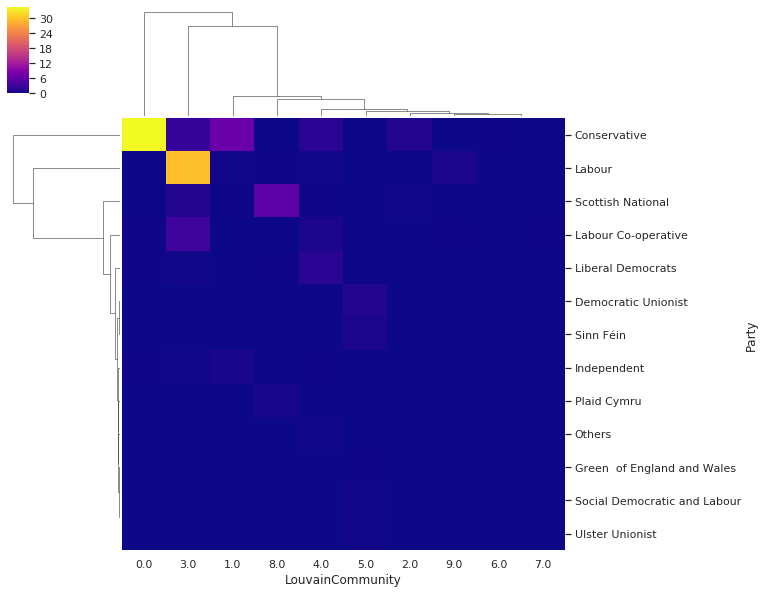

In [0]:
house_of_commons['LouvainCommunity'] = house_of_commons.twi_handle.map(partition)
conf_table = (pd.crosstab(house_of_commons.Party, house_of_commons.LouvainCommunity)/len(house_of_commons)) *100
sns.clustermap(conf_table, cmap='plasma')

As we can see in the plot, the two main parties (Conservative and Labour) are being identified pretty well. It's difficult to see how is working with the rest of the parties, so let's plot the network to take a look to the communities.

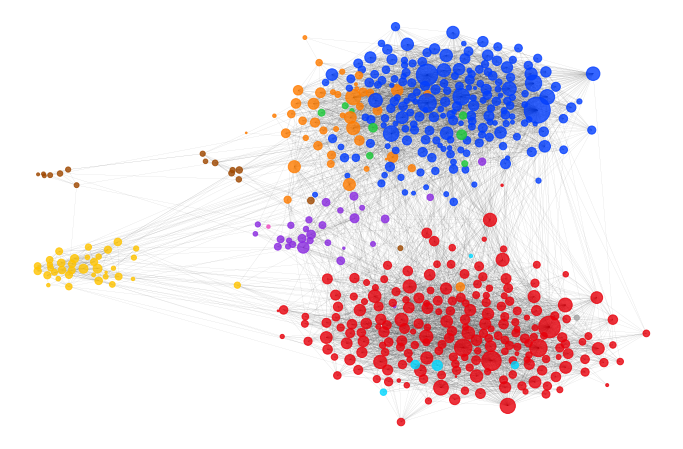

In [0]:
# set our color palette
palette = sns.color_palette("bright", n_colors=len(set(partition.values())))

#create the list of colors
community_color  = [palette[partition[node]] for node in undirected.nodes]

nx.draw_networkx(undirected, positions, 
                 node_size=[3*v  for v in dict(nx.degree(undirected)).values()], 
                 with_labels=False, width=0.05, node_color=community_color, alpha=0.8)
plt.axis('off')
plt.show()

As we mentioned previously, the Conservative and Labour parties are being identified pretty well. Nevertheless, the algorithm is having more difficulties to find the rest of the parties. It groups in one community most of the members of the Scottish National party, but the results are not the best for the rest of cases.

### Incorporate Sentiment into our Analysis

In this section we've used the Tweeter API to catch tweets from members of the HOC back from 2016 until today. Then using the TextBlob library, we've calculated the sentiment score of their tweets to try to know how they fill about the Brexit.

The file _MembersBrexitTweetsSentimentScore.csv_ contains tweets from the HOC members with some useful data about them, such as number of retweets, number of favorites and the computed sentiment score.

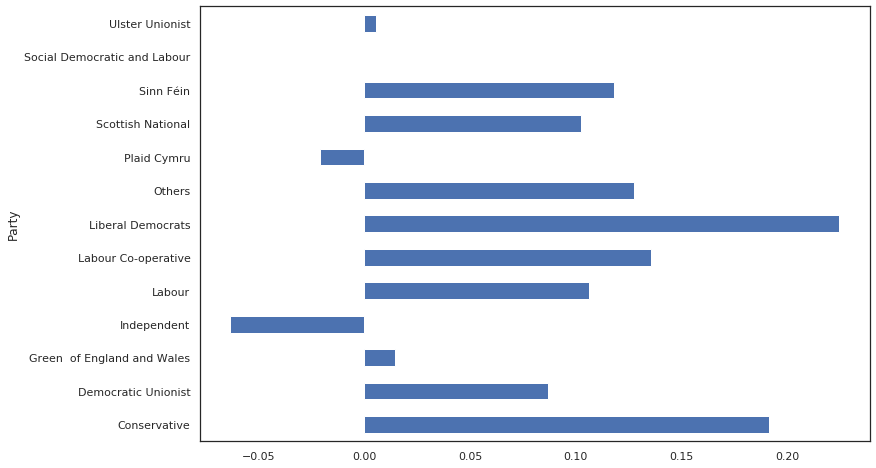

In [0]:
sentiment_score = pd.read_csv('MembersBrexitTweetsSentimentScore.csv')
sentiment_score = sentiment_score.rename(columns = {'Name': 'twi_handle'})
sentiment_score = pd.merge(house_of_commons, sentiment_score, on='twi_handle')
sentiment_score.groupby('Party').mean()['SentimentScore'].plot(kind='barh')

The upper plot shows the results of the sentiment analysis grouped by party. There are two parties with a negative score: Plaid Cymru (Party of Wales) and independents (not affiliated with any political party). We know that Plaid Cymru is against Brexit but the independents can have different political opinions. Moreover, we know that some of the parties with a positive sentiment score are also against Brexit (for example the Scottish National Party).

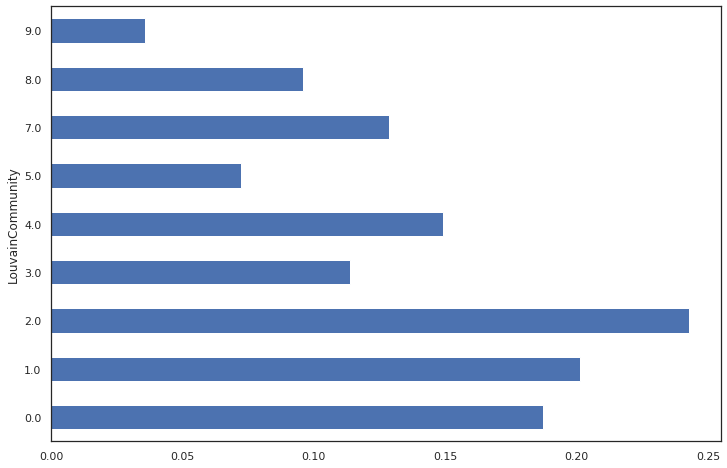

In [0]:
sentiment_score.groupby('LouvainCommunity').mean()['SentimentScore'].plot(kind='barh')

If we group the results by the communities previously generated using the Louvain method we obtain the upper plot. 

Taking a look to both plots we can conclude then that we can't guess the position about Brexit by party or community using this method with the data that we have.

In [0]:
map_dict = dict(enumerate(set(sentiment_score.SentimentScore.round(2))))
inv_map = {v: k for k, v in map_dict.items()}

In [0]:
sentiment_pallette = sns.diverging_palette(0, 150, n=len(map_dict))

In [0]:
sentiment_color = []
for node in undirected.nodes:
    try:
        value = sentiment_score.SentimentScore[sentiment_score.twi_handle == node].round(2).values[0]
    except Exception as e:
        value = 0
    sentiment_color.append(sentiment_pallette[inv_map[value]])

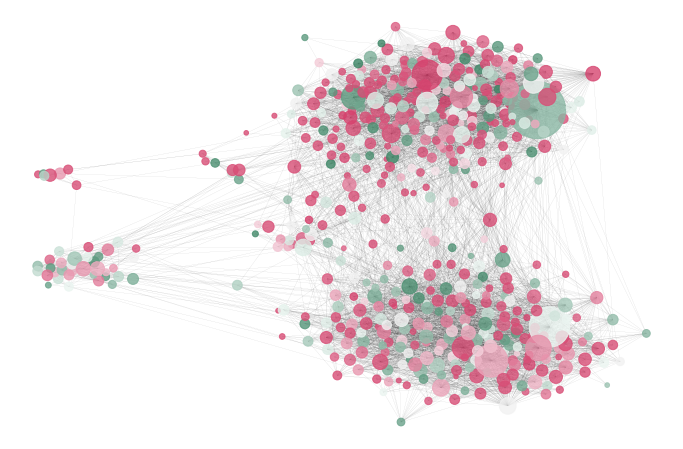

In [0]:
nx.draw_networkx(undirected, positions, 
                 node_size=[60000*v  for v in dict(nx.pagerank(undirected)).values()], 
                 with_labels=False, width=0.05, 
                 node_color=sentiment_color, 
                 alpha=0.8)
plt.axis('off')
plt.show()

In the upper network we are using the sentiment score from each politician to show an overview of the HOC. As we can see, the sentiment score is not directly related to each party's position about Brexit according to the previous conclusions.

### Conclusions

The network provides a good overview of the HOC: the parties and how are the relations between them, the most influential members of each party, etc. But it's difficult to make conclusions of their position about Brexit only with the sentiment analysis, so that's why we are going to continue with our Brexit analysis in the next sections.

## Text Analysis

In this section we throughly analyse the tweets obtained with the _GetOldTweets3_ library to get more insights on the the members of HOC, as well as the general public opinion on Brexit.

The analysis is structured in various sections, performing analysis on parties, on important members of the HOC, as well as the public opinion.

In [0]:
#libraries and functions for text analysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.decomposition import LatentDirichletAllocation


import string

def text_processing(text):
    # remove punctuation 
    text = "".join([c for c in text 
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    text = " ".join([w for w in text.split() 
                     if w not in stop_words.ENGLISH_STOP_WORDS])
    # stemming / lematizing (optional)
    #text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    text = text.replace('https', '')
    return text

def read_csv(filename):
    tweets = pd.read_csv(filename, index_col=0)[['text', 'Name', 'Party', 'Polarity']]
    tweets.text = tweets.text.swifter.apply(text_processing)
    tweets.index = pd.to_datetime(tweets.index)
    return tweets

def freq_wordcloud(frequencies, background_color='white'):
    wordcloud = WordCloud( 
        background_color=background_color,
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    )
    wordcloud.generate_from_frequencies(frequencies=frequencies)
    return wordcloud


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=3,
    ).generate(str(data))

    fig = plt.figure(1, figsize=(6, 6))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [0]:
#import more politician tweets
brexit_df= read_csv('politician_tweets_#brexit.csv')
leave_df = read_csv("politician_tweets_#leave.csv")
remain_df = read_csv("politician_tweets_#remain.csv")

leave_df['Category'] = 'leave'
remain_df['Category'] = 'remain'
full_df = leave_df.append(remain_df.sample(len(leave_df), random_state=7))

In [0]:
brexit_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 787 entries, 2016-09-01 to 2019-02-01
Data columns (total 4 columns):
text        787 non-null object
Name        787 non-null object
Party       787 non-null object
Polarity    787 non-null float64
dtypes: float64(1), object(3)
memory usage: 30.7+ KB


In [0]:
leave_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3198 entries, 2017-03-01 to 2019-08-01
Data columns (total 5 columns):
text        3198 non-null object
Name        3198 non-null object
Party       3198 non-null object
Polarity    3198 non-null float64
Category    3198 non-null object
dtypes: float64(1), object(4)
memory usage: 149.9+ KB


In [0]:
remain_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8867 entries, 2018-12-01 to 2019-05-01
Data columns (total 5 columns):
text        8867 non-null object
Name        8867 non-null object
Party       8867 non-null object
Polarity    8867 non-null float64
Category    8867 non-null object
dtypes: float64(1), object(4)
memory usage: 415.6+ KB


In [0]:
#import public tweets
general_tweets = pd.read_csv('general_public_tweets.csv', index_col=0)
leave_tweets = pd.read_csv('leave_public_tweets.csv', index_col=0)
stay_tweets = pd.read_csv('stay_public_tweets.csv', index_col=0)

### Party Tweets Analysis

The plot below shows the distribution of the polarity measure for tweets of the members of HOC containing the #brexit hashtag. We can see that negative and positive tweets are evenly distributed around zero.

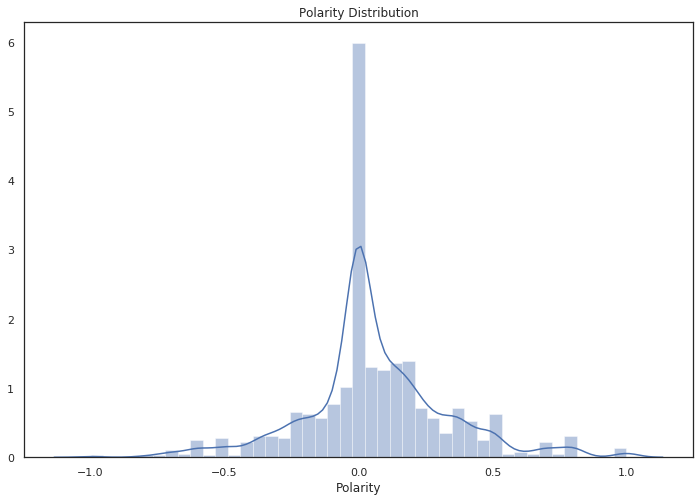

In [0]:
plt.title("Polarity Distribution")
sns.distplot(brexit_df.Polarity)

In [0]:
# select the most negative and positive tweets
most_negative = brexit_df.sort_values(by='Polarity').text.head(100).sum()
most_positive = brexit_df.sort_values(by='Polarity').text.tail(100).sum()

In [0]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform([most_negative])
negative_d = dict(zip(tfidf_vectorizer.get_feature_names(), list(tfidf.toarray()[0])))

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform([most_positive])
positive_d = dict(zip(tfidf_vectorizer.get_feature_names(), list(tfidf.toarray()[0])))

Now we are going to select the top 100 positive and negative tweets and compute their TF-IDF. Then we are going to use this TF-IDF values to plot two wordclouds with the most representative words we can found in the negative and positive tweets, respectively.

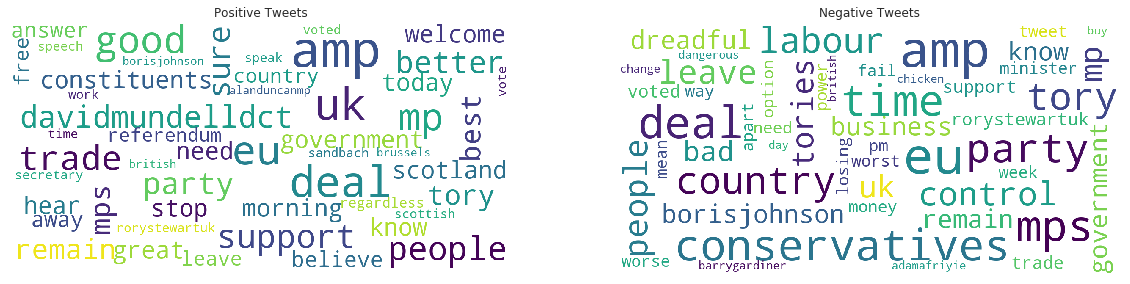

In [0]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(1,2,1)
plt.title("Positive Tweets")
wordcloud_1 = freq_wordcloud(positive_d)
ax.imshow(wordcloud_1)
ax.axis('off')
ax = fig.add_subplot(1,2,2)
plt.title("Negative Tweets")
wordcloud_2 = freq_wordcloud(negative_d, background_color='white')
ax.imshow(wordcloud_2)
ax.axis('off')
plt.show()

Let's see what are the parties thinking. We are going to create a wordcloud for each one of them. Then, based on these wordclouds, we are going to make some conclusions about the reasoning behind each political party's position on Brexit. For example, in the Conservative Party's wordcloud the dominant words are "constituent", "trade", "great", "benefit" and "business", which indicates their belief that Brexit could benefit the economy and trade.

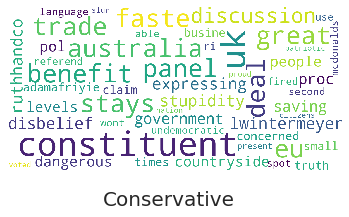

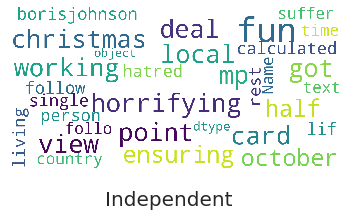

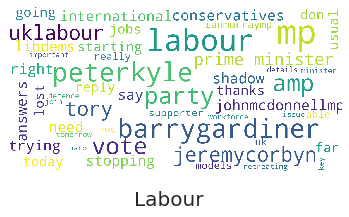

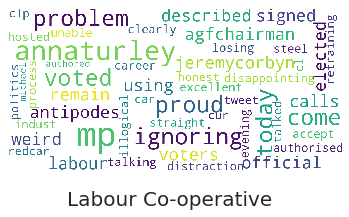

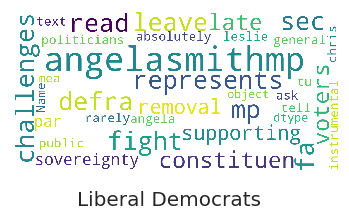

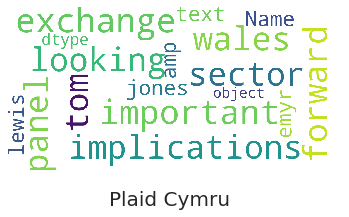

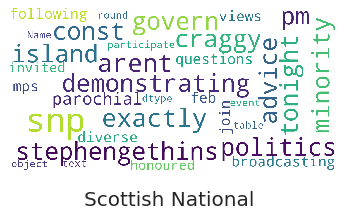

Empty DataFrame
Columns: []
Index: []

In [0]:
brexit_df.groupby('Party').apply(
    lambda x: show_wordcloud(x.text, title=f"{x.name}")
)

Below we are plotting the number of #leave and #remain tweets for each party in HOC. We can see that Conservatives and Labours are have the largest number of tweets in both cases and that Conservatives tweet more with #leave and Labours more with #remain, which probably can tell us something about their position about Brexit.

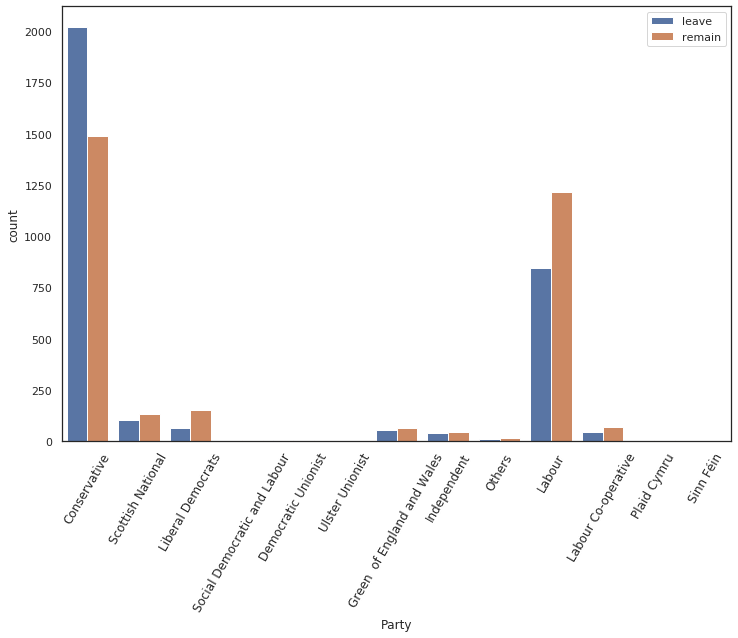

In [0]:
sns.countplot(x='Party', data=full_df, hue='Category')
plt.xticks(fontsize=12, rotation='60')
plt.legend(loc='best')
plt.show()

### Important Members of HOC Tweet Analysis

In [0]:
# selecting the tweets of the top members based on connectivity metrics
top_members_df = full_df[full_df.Name.isin(top)]

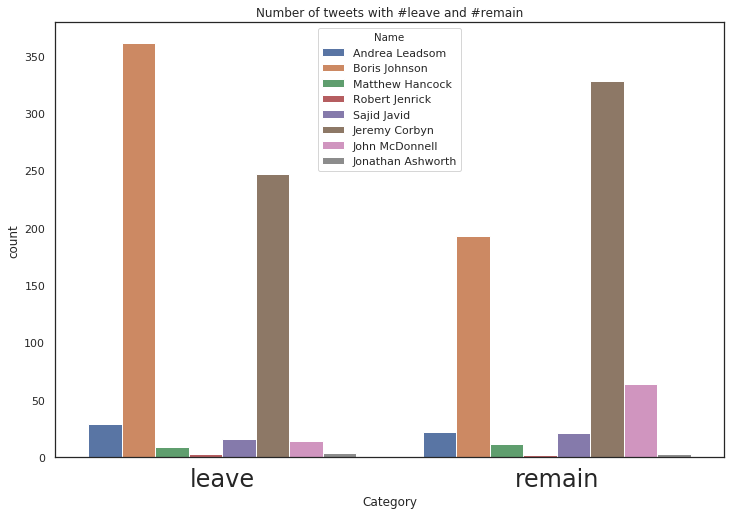

In [0]:
plt.title("Number of tweets with #leave and #remain")
sns.countplot(x='Category', data=top_members_df, hue='Name')
plt.xticks(fontsize=24)
plt.show()

By plotting the number of tweets we get an even more clear picture of where each party stands on Brexit's dilemma. Moreover, we can see that the leaders of the two largest parties have the higher number of tweets, and also that the other important members of these parties tend to follow their leaders.

In [0]:
md = {top_i: list(house_of_commons[house_of_commons.Name==top_i].Party.unique())[0] 
      for top_i in top}
top_members = pd.DataFrame().from_dict(md,orient='index', columns=['Party'])
top_members

Party
Jonathan Ashworth  Labour Co-operative
Lindsay Hoyle                   Labour
Andrea Leadsom            Conservative
Matthew Hancock           Conservative
Boris Johnson             Conservative
John McDonnell                  Labour
Sajid Javid               Conservative
Robert Jenrick            Conservative
Jeremy Corbyn                   Labour

These are the politicians and below are their respective wordclouds.

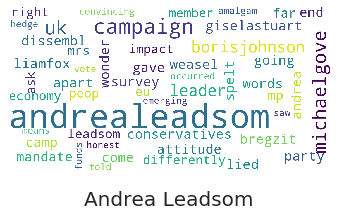

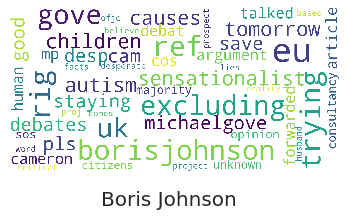

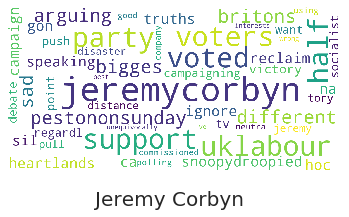

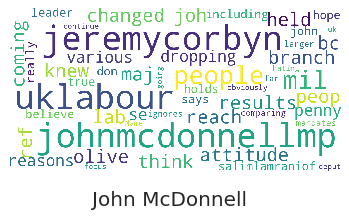

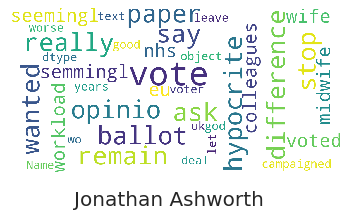

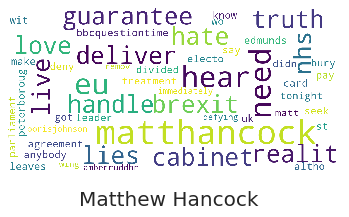

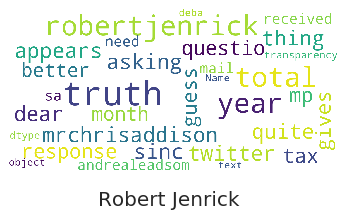

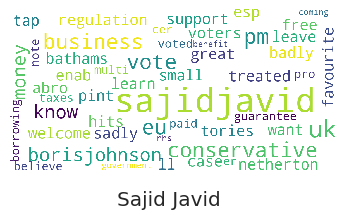

Empty DataFrame
Columns: []
Index: []

In [0]:
top_members_df.groupby('Name').apply(
    lambda x: show_wordcloud(x.text, title=f"{x.name}")
)

### Detected Community Tweets Analysis

In [0]:
full_df['handles'] = full_df.Name.map(names_to_handles)
full_df['Community'] = full_df.handles.map(partition)

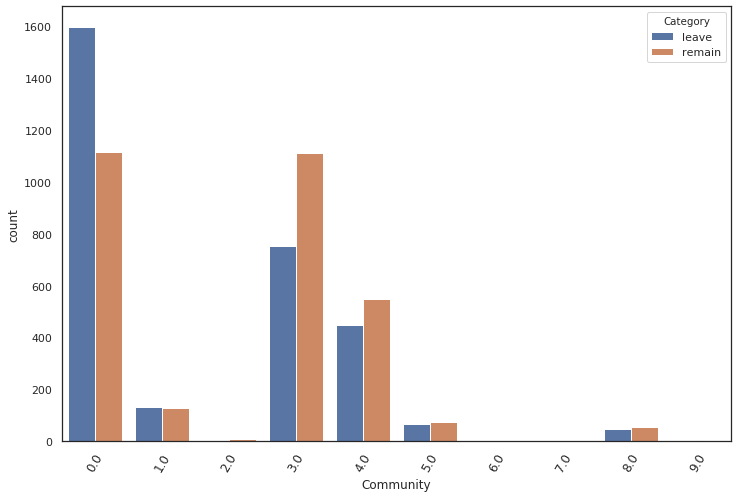

In [0]:
sns.countplot(x='Community', data=full_df, hue='Category')
plt.xticks(fontsize=12, rotation='60')
plt.show()

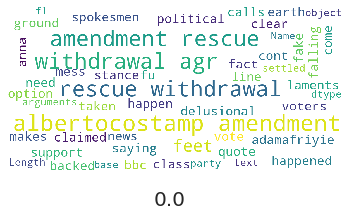

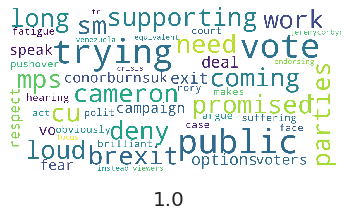

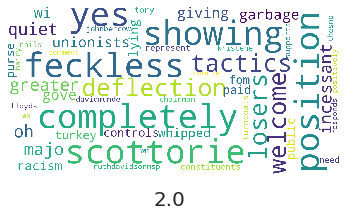

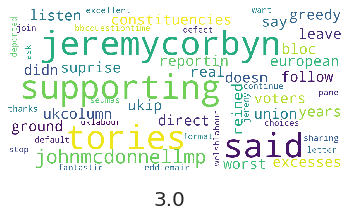

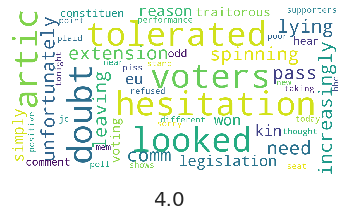

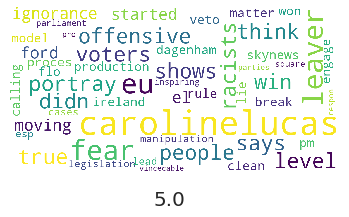

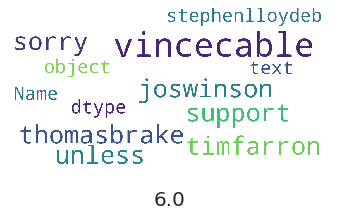

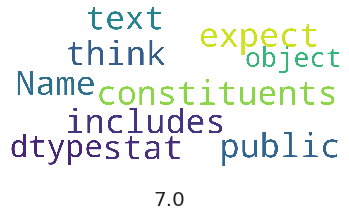

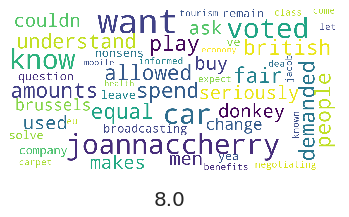

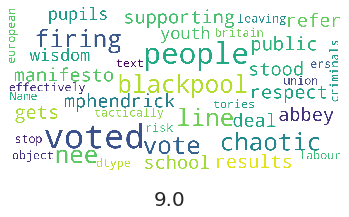

Empty DataFrame
Columns: []
Index: []

In [0]:
full_df.groupby('Community').apply(
    lambda x: show_wordcloud(x.text, title=f"{x.name}")
)


### Topic Modeling

In this section we have used the _Latent Dirichlet Allocation_ implementation of the _Sklearn_ library on the tweets from #leave and #remain hashtags in order to provide some topic modelling. By visualising these topics we expect to get some more insight on the different aspects of Brexit, but also we can compare the topics from the public tweets to those of the politician to see the different pespectives of each group.

In [0]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [0]:
def topicWordCloud(model,feature_names, topicNumber):
    topic = model.components_[topicNumber]
    tupleList = [(feature_names[i],int(topic[i]/topic.sum()*10000)) 
                 for i in range(len(topic))]
    wordcloud = WordCloud(background_color='white',
                          width=600, 
                          height=600, 
                          max_words=50,
                          #colormap='prism',
                          random_state=42).generate_from_frequencies(dict(tupleList))
    return wordcloud


no_features = 1000

def visualize_topics(df):   
    # LDA can only use raw term counts for LDA because it is a probabilistic graphical model
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(df.text)
    tf_feature_names = tf_vectorizer.get_feature_names()
    no_topics = 9
    lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

    fig = plt.figure(figsize=(20,20))
    plt.title("#Stay")

    for i in range(no_topics):
        ax = fig.add_subplot(3,3,i+1)
        wordcloud = topicWordCloud(lda, tf_feature_names, i)
        ax.imshow(wordcloud)
        ax.axis('off')
    plt.axis('off')
    plt.show()

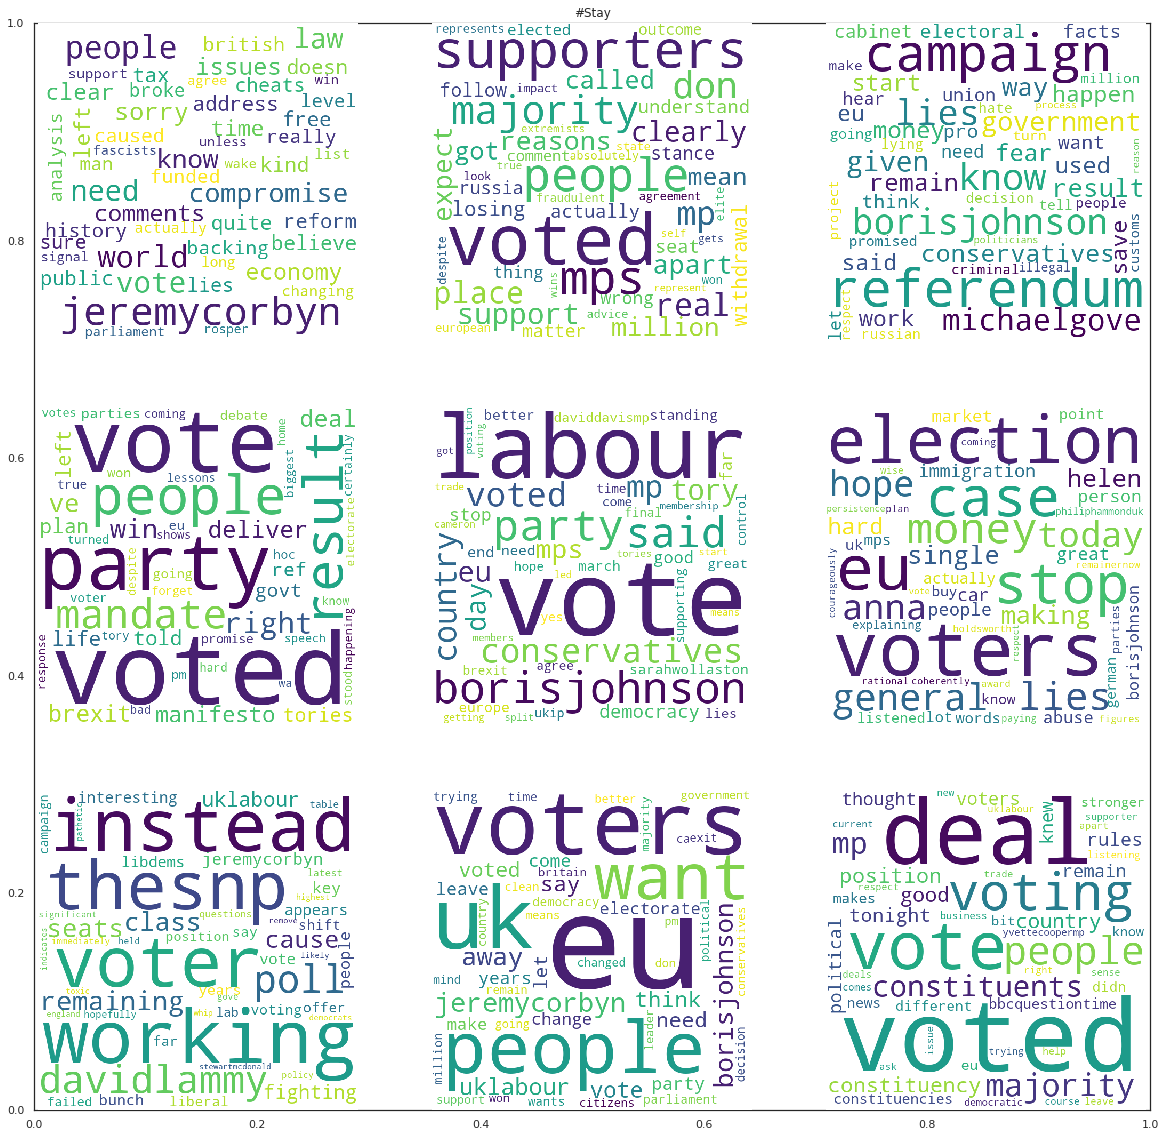

In [0]:
visualize_topics(leave_df)

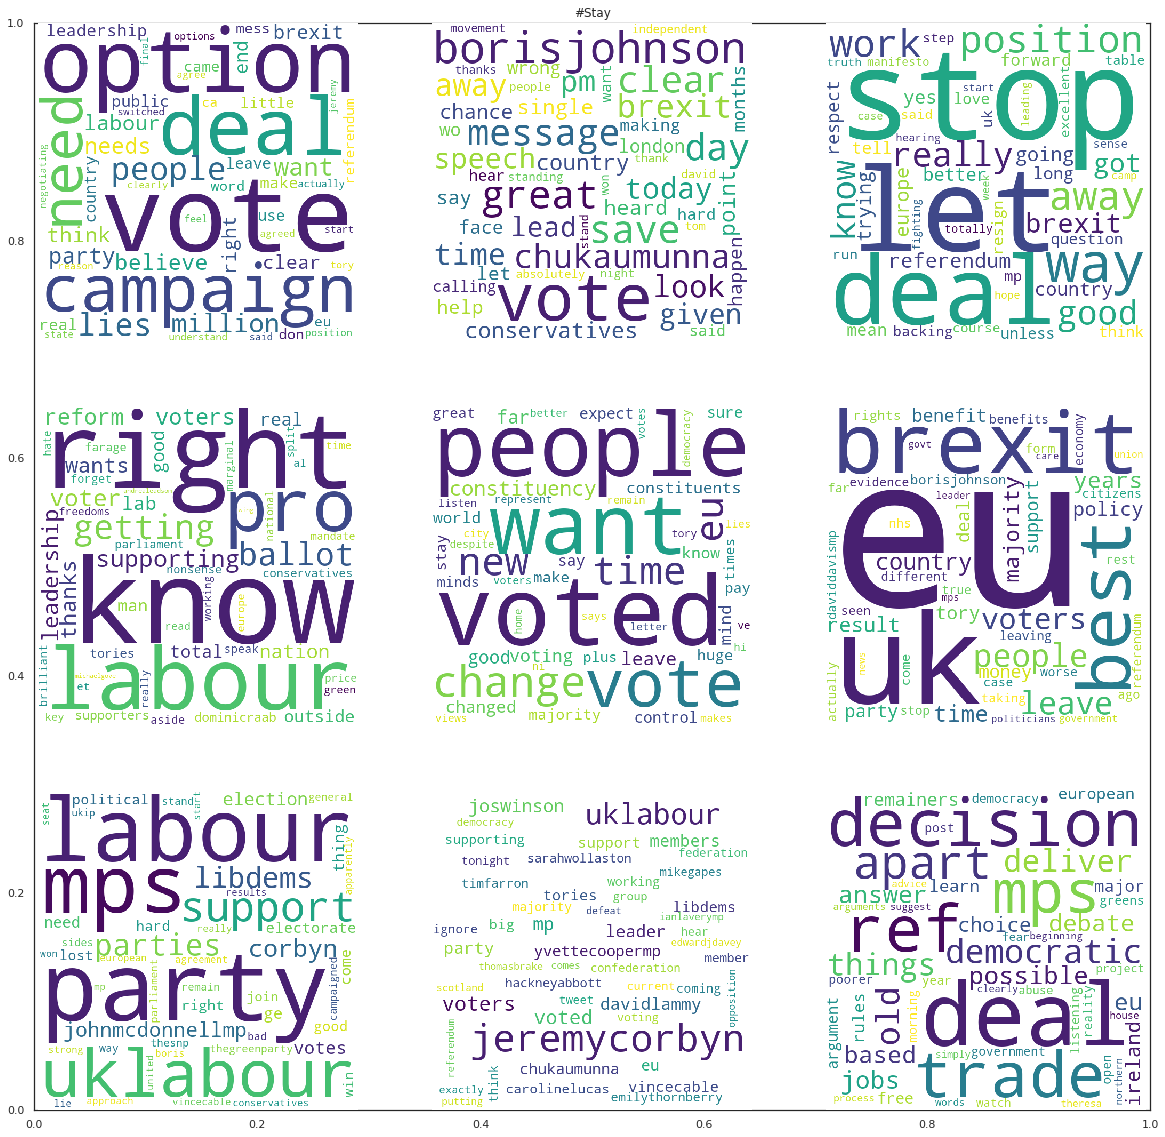

In [0]:
visualize_topics(remain_df)

By looking at the topics of the politician tweets we can't really get much meaningful information. On one hand we notice that, for example, in one of the topics generated from the #leave hashtag, Boris Johnson, the leader of Conservatives, is grouped with words such as "lies" and "fear". Meanwhile, words like "EU", "Corbyn" or "Labour" appear together in more than one topic. On the other hand, topics generated from #stay hashtag seem to be about "democracy", "Labour Party", "changing", "vote", etc.

## General Public Tweets Analysis

By analysing the public tweets we expect to see what the public opinion thinks about Brexit over time and, in addition to that, what are the main concerns of people no directly connected to the political parties related with Brexit. 

In [0]:
stay_df = pd.read_csv('stay_public_tweets.csv', index_col=0)
stay_df.text = stay_df.text.swifter.apply(text_processing)
stay_df.index = pd.to_datetime(stay_df.index)

leave_df = pd.read_csv('leave_public_tweets.csv', index_col=0)
leave_df.text = leave_df.text.swifter.apply(text_processing)
leave_df.index = pd.to_datetime(leave_df.index)

general_df = pd.read_csv('general_public_tweets.csv', index_col=0)
general_df.text = general_df.text.swifter.apply(text_processing)
general_df.index = pd.to_datetime(general_df.index).strftime('%m/%Y')

#### Sentiment over time

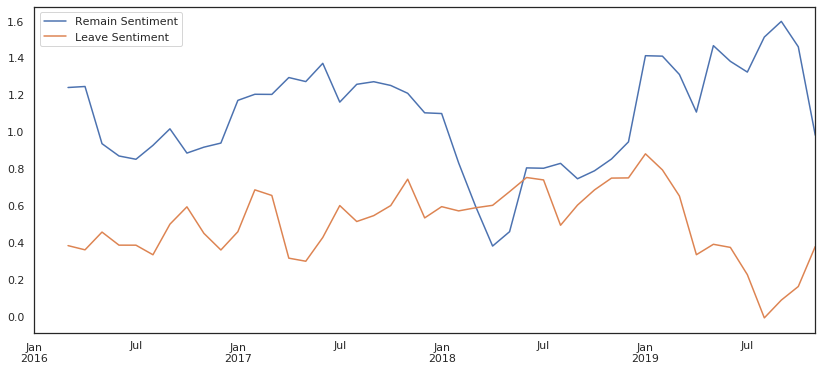

In [0]:
plt.figure(figsize=(14,6))
stay_df.Sentiment_Score.rolling(3).mean().plot(label='Remain Sentiment')
leave_df.Sentiment_Score.rolling(3).mean().plot(label='Leave Sentiment')
plt.legend(loc='best')

We are using a rolling average of 3 months to make the plot sentiment smoother. By looking at the trends we can see that the public opinion linked to the #leave hashtag has a downward trend after January 2019, while #remain (although it took a hit in the middle of 2018) seems to have an upward trend in 2019. We can view this as an indication that the general public is slightly against Brexit.

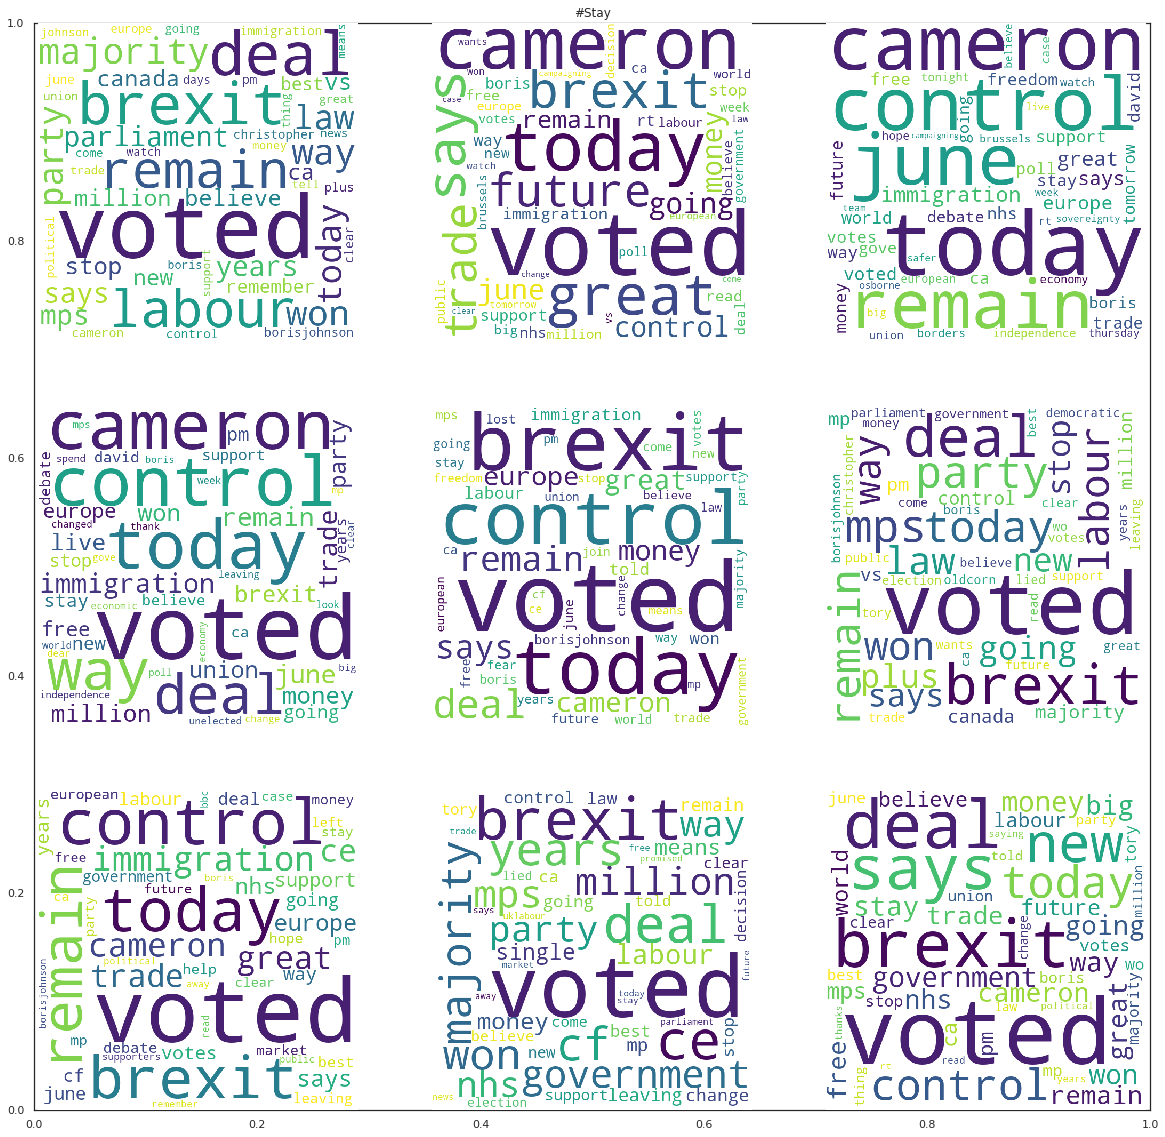

In [0]:
visualize_topics(leave_df)

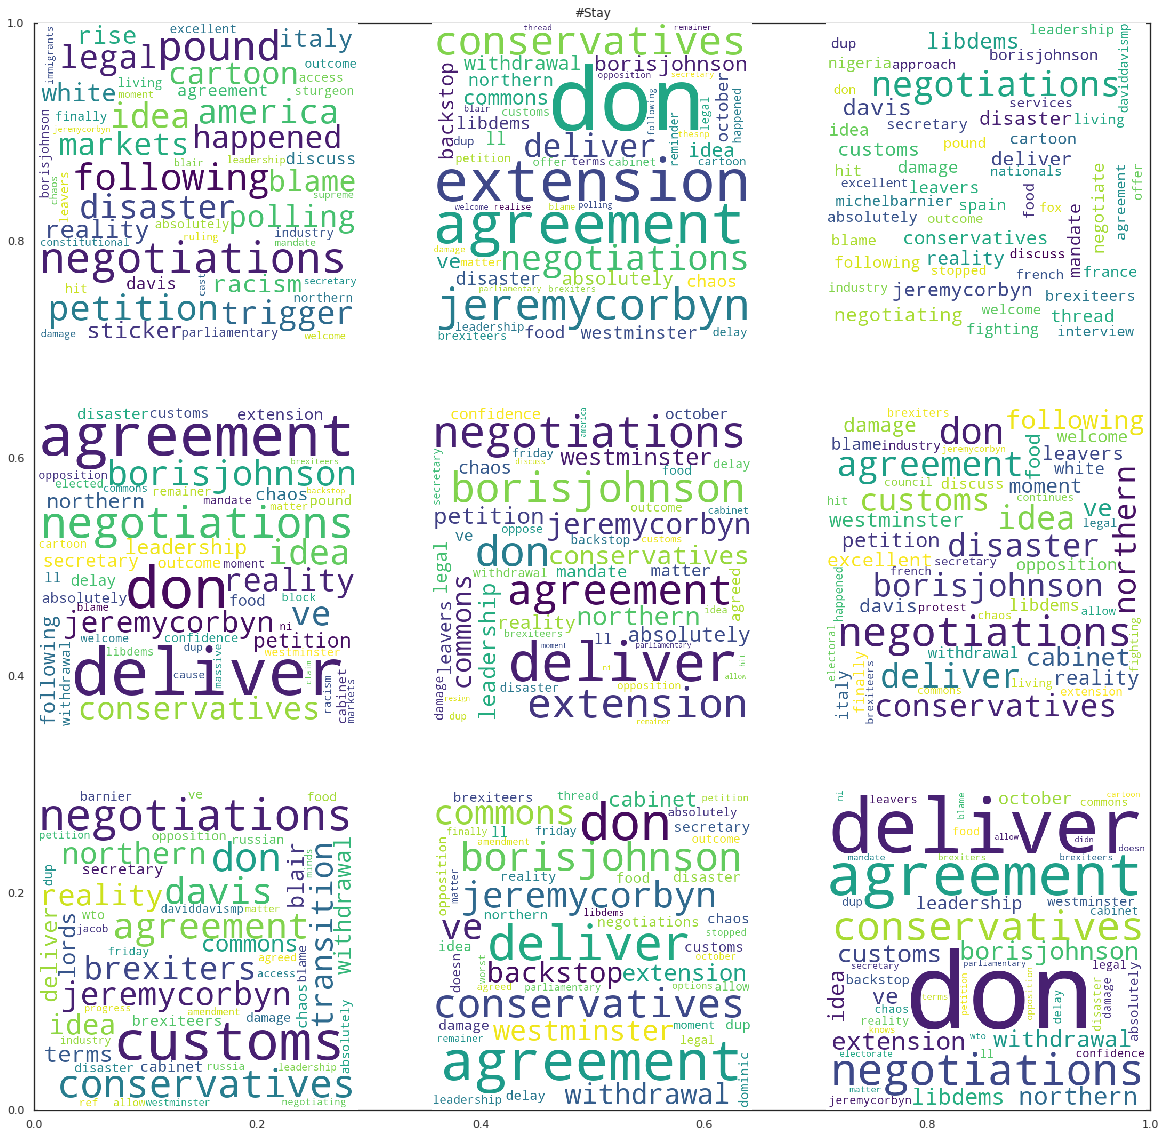

In [0]:
visualize_topics(general_df)

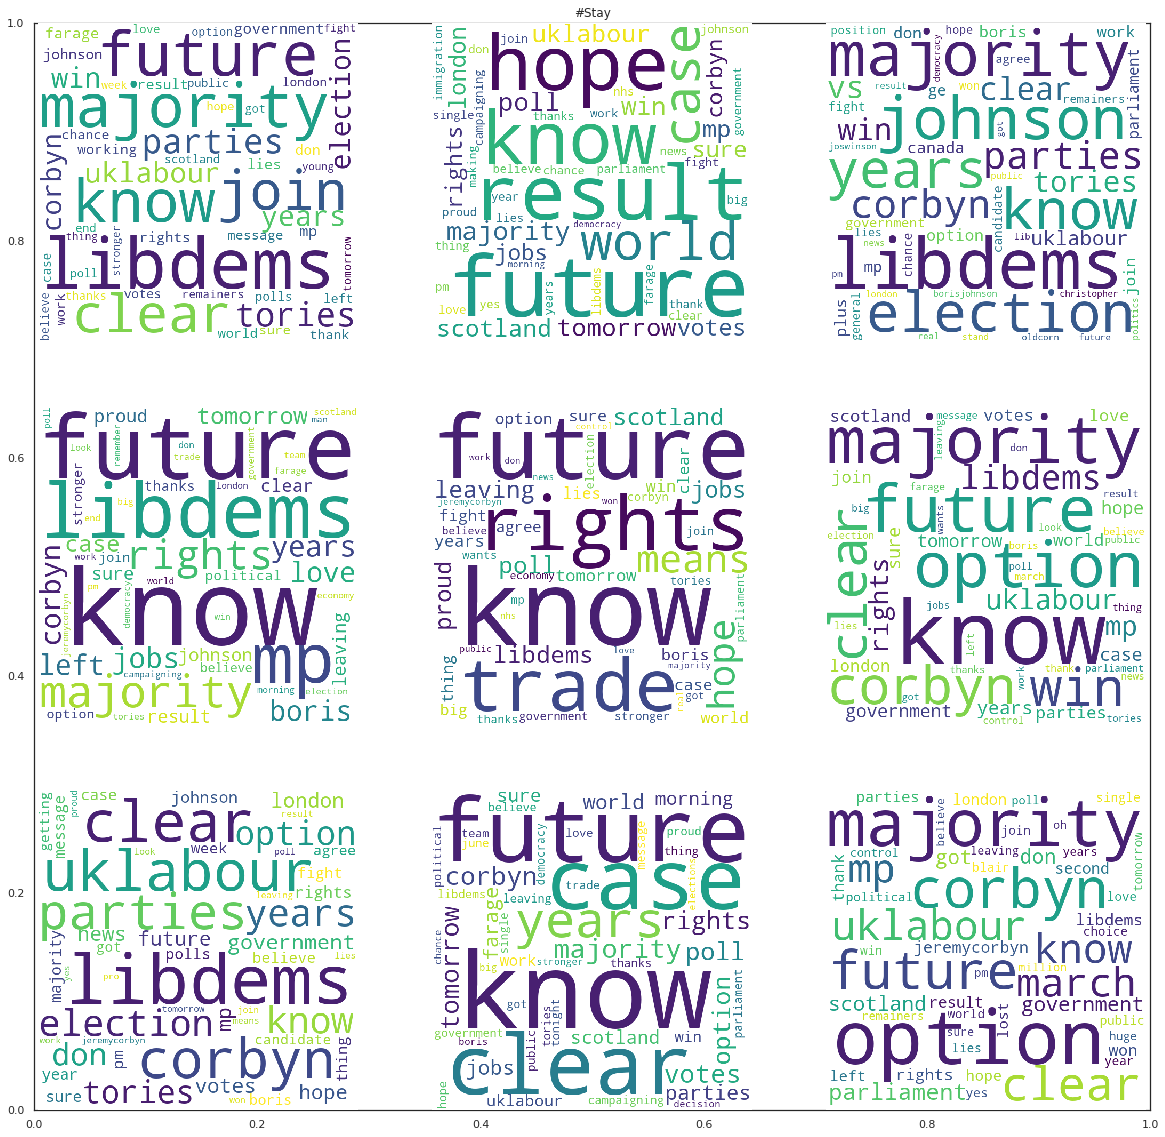

In [0]:
visualize_topics(stay_df)

On one hand, observing the topics generated from the public tweets using the #leave hashtag, we can say that people pro-Brexit are concerned about immigration, control, trade, future, as well as many topics about voting. On the other hand, the #remain tweets generates topics about future, option, rights, and Liberal Democrats. The general hashtag group (containing hashtags like #brexit, #euref, etc.) generates topics about parties, negotiation or agreement.

These tweets and the topics can be used to get more information using sentiment analysis and, possibly, make some predictions on what the public in going to vote in the upcoming elections.

## Conclusions

The main scope of this project is to explore the reactions to Brexit, paying attention to the british politicians and the citizens of the United Kingdom (UK), in order to provide an overview of the evolution of the whole process during the last three years. Using free sources like Twitter, Wikipedia or The Guardian, and our Network Analysis and Text Analysis toolbox, we were able to extract some meaningful information and gain some insights on the political situation and the power struggle surrounding Brexit.

Through our analysis we managed to identify the key players on the british political scene using the Twitter network that we created and its centrality measures. Moreover, using the Louvain community algorithm we tried to identify some division inside the political parties in order to find disagreements between their members, although without much success.

In addition to that, we used some sentiment analysis tools (such as _TextBlob_ or _Scikit-learn_) to extract information from the tweets of the politicians and the general public. By constructing wordclouds and generating topics (with LDA) we managed to gain an idea of the main issues and problematics of the Brexit situation, both from the politicians perspective as well as the common people.

If we talk about possible future improvements, we hope that we will be able to enrich and use this analysis with tools from network dynamics and machine learning. With that, we could predict the time evolution of the network graph (based on it's structure over time) as well as some useful meta information (like social analysis, twitter, etc.).